In [8]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from skfuzzy.cluster import cmeans
from sklearn.metrics import silhouette_score

## define bucket in which you are trying to reach
s3 = boto3.resource('s3')
bucket_name = 'daltondencklau-data445-bucket'
bucket = s3.Bucket(bucket_name)

## define csv file to read in the bucket
file_key= 'customers.csv'

## syntax to allow us to read the file
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## reading the data file
customers = pd.read_csv(file_content_stream)
customers.head()

,ID,Visit_Time,Average_Expense,Sex,Age
0,1,3,5.7,0,10
1,2,5,14.5,0,27
2,3,16,33.5,0,32
3,4,5,15.9,0,30
4,5,16,24.9,0,23


In [6]:
pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 41.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=73b3101eda988dad3ee6927d8b9fb8b142905ecc50235fc6dee362db6817fe5a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/2c/04/80/7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
## removing the ID column
customers = customers.drop(columns = 'ID')

In [10]:
## scaling the data (0-1)
scaler = MinMaxScaler()
customers[['Visit_Time_0_1', 'Average_Expense_0_1', 'Sex_0_1', 'Age_0_1']] = scaler.fit_transform(customers)

In [11]:
customers.head()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1
0,3,5.7,0,10,0.117647,0.041096,0.0,0.051282
1,5,14.5,0,27,0.235294,0.342466,0.0,0.487179
2,16,33.5,0,32,0.882353,0.993151,0.0,0.615385
3,5,15.9,0,30,0.235294,0.390411,0.0,0.564103
4,16,24.9,0,23,0.882353,0.698630,0.0,0.384615


In [13]:
## defining list to store silhouette scores
silhouette = list()

for i in range (2, 21):
    
    ## clustering the data into i clusters
    kmeans_md = KMeans(n_clusters = i, n_init = 20).fit(customers[['Visit_Time_0_1', 'Average_Expense_0_1', 'Sex_0_1', 'Age_0_1']])
    
    ## extracting labels
    kmeans_md_labels = kmeans_md.labels_
    
    ## extracting silhouette score
    score = silhouette_score(customers[['Visit_Time_0_1', 'Average_Expense_0_1', 'Sex_0_1', 'Age_0_1']], kmeans_md.labels_)
    
    ## apending results to list
    silhouette.append(score)

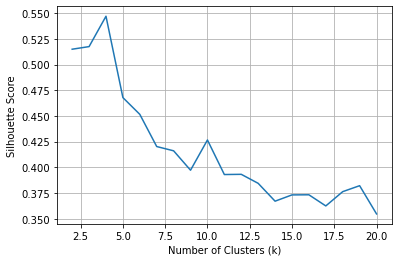

In [15]:
plt.plot(range(2,21), silhouette)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show();

In [ ]:
## we will use four clusters (based on above graph) in the next model

In [16]:
X = customers[['Visit_Time_0_1', 'Average_Expense_0_1', 'Sex_0_1', 'Age_0_1']]

## running Fuzzy C means using 4 clusters
fc, W, u0, d, jm, p, pc = cmeans(X.T, c = 4, m = 1.25, error = 1e-6, maxiter = 1000)

In [18]:
## likelihoods accociated to [cluster(k)]
W[0]

array([[6.31011173e-06, 7.85104329e-06, 6.61744521e-05, 8.69868688e-05,
        8.18636983e-08, 7.90149527e-09, 9.27550989e-06, 6.69309731e-06,
        1.84907252e-04, 5.96184880e-06, 1.15925230e-07, 4.09311093e-07,
        9.27550989e-06, 2.51650506e-07, 3.82032069e-06, 8.22970159e-06,
        9.87485590e-08, 2.19918698e-06, 1.41320931e-05, 9.95286039e-01,
        2.07871833e-07, 9.94249539e-01, 1.30047947e-05, 9.97647232e-01,
        9.99994350e-01, 2.12348937e-05, 3.01669215e-07, 9.99936867e-01,
        5.50328517e-10, 1.88251955e-04, 1.28661336e-03, 9.99999837e-01,
        9.99999259e-01, 9.99707582e-01, 1.88251955e-04, 2.30237226e-07,
        9.99827860e-01, 1.05459649e-04, 6.36467988e-08, 2.07871833e-07,
        1.85976686e-05, 2.88634733e-04, 3.50185953e-06, 3.92805705e-02,
        9.99980175e-01, 9.99936867e-01, 2.30732866e-01, 1.00671284e-05,
        1.30802508e-03, 9.97647232e-01, 1.93846315e-05, 9.88770902e-01,
        9.99814921e-01, 7.94348493e-04, 3.85581038e-01, 3.163308

In [21]:
## creating cluster column
customers['cluster'] = np.nan

## changing likelihoods to labels
customers['cluster'] = np.where(W[0] > 0.7, 1, customers['cluster'])
customers['cluster'] = np.where(W[1] > 0.7, 2, customers['cluster'])
customers['cluster'] = np.where(W[2] > 0.7, 3, customers['cluster'])
customers['cluster'] = np.where(W[3] > 0.7, 4, customers['cluster'])

In [23]:
## Cluster 1
cluster_1 = customers[customers['cluster'] == 1].reset_index(drop = True)
cluster_1.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,16.000000,16.000000,16.0,16.000000,16.000000,16.000000,16.0,16.000000,16.0
mean,12.250000,25.362500,1.0,31.187500,0.661765,0.714469,1.0,0.594551,1.0
std,2.955221,4.336339,0.0,8.336416,0.173837,0.148505,0.0,0.213754,0.0
min,8.000000,17.800000,1.0,17.000000,0.411765,0.455479,1.0,0.230769,1.0
25%,10.000000,21.100000,1.0,26.000000,0.529412,0.568493,1.0,0.461538,1.0
50%,12.000000,25.450000,1.0,28.500000,0.647059,0.717466,1.0,0.525641,1.0
75%,13.250000,28.275000,1.0,36.750000,0.720588,0.814212,1.0,0.737179,1.0
max,18.000000,33.700000,1.0,47.000000,1.000000,1.000000,1.0,1.000000,1.0


In [24]:
## Cluster 2
cluster_2 = customers[customers['cluster'] == 2].reset_index(drop = True)
cluster_2.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,24.000000,24.000000,24.0,24.000000,24.000000,24.000000,24.0,24.000000,24.0
mean,5.416667,10.591667,1.0,15.291667,0.259804,0.208619,1.0,0.186966,2.0
std,2.430185,4.474752,0.0,4.666990,0.142952,0.153245,0.0,0.119666,0.0
min,1.000000,4.500000,1.0,8.000000,0.000000,0.000000,1.0,0.000000,2.0
25%,3.000000,7.875000,1.0,11.750000,0.117647,0.115582,1.0,0.096154,2.0
50%,6.000000,10.900000,1.0,16.000000,0.294118,0.219178,1.0,0.205128,2.0
75%,7.000000,12.000000,1.0,17.500000,0.352941,0.256849,1.0,0.243590,2.0
max,10.000000,23.800000,1.0,23.000000,0.529412,0.660959,1.0,0.384615,2.0


In [25]:
## Cluster 3
cluster_3 = customers[customers['cluster'] == 3].reset_index(drop = True)
cluster_3.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,11.000000,11.000000,11.0,11.00000,11.000000,11.000000,11.0,11.000000,11.0
mean,4.909091,12.709091,0.0,17.00000,0.229947,0.281133,0.0,0.230769,3.0
std,1.700267,6.060108,0.0,6.78233,0.100016,0.207538,0.0,0.173906,0.0
min,3.000000,4.600000,0.0,9.00000,0.117647,0.003425,0.0,0.025641,3.0
25%,3.500000,7.150000,0.0,12.00000,0.147059,0.090753,0.0,0.102564,3.0
50%,5.000000,14.500000,0.0,16.00000,0.235294,0.342466,0.0,0.205128,3.0
75%,6.000000,16.000000,0.0,20.00000,0.294118,0.393836,0.0,0.307692,3.0
max,8.000000,23.800000,0.0,30.00000,0.411765,0.660959,0.0,0.564103,3.0


In [26]:
## Cluster 4
cluster_4 = customers[customers['cluster'] == 4].reset_index(drop = True)
cluster_4.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Sex_0_1,Age_0_1,cluster
count,8.000000,8.000000,8.0,8.000000,8.000000,8.000000,8.0,8.000000,8.0
mean,14.375000,25.587500,0.0,26.625000,0.786765,0.722175,0.0,0.477564,4.0
std,1.846812,4.647714,0.0,5.629958,0.108636,0.159168,0.0,0.144358,0.0
min,12.000000,18.800000,0.0,18.000000,0.647059,0.489726,0.0,0.256410,4.0
25%,13.500000,22.950000,0.0,22.750000,0.735294,0.631849,0.0,0.378205,4.0
50%,14.000000,25.400000,0.0,26.000000,0.764706,0.715753,0.0,0.461538,4.0
75%,16.000000,28.500000,0.0,32.250000,0.882353,0.821918,0.0,0.621795,4.0
max,17.000000,33.500000,0.0,33.000000,0.941176,0.993151,0.0,0.641026,4.0


In [ ]:
## describe each of the clusters:

## clusters 1 and 2 appear to be mostly males, with cluster 1 having older males and cluster 2 containing younger males. Clusters
## 3 and 4 appear to be females.

## Cluster 3 contains younger females, whereas, cluster 4 contains older females.

## the older males and females (cluster 1 and 4) appear to have higher average expenses and visit times.